In [2]:
import random
from typing import Dict, List, Tuple, Optional
import json

import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from IPython.display import clear_output


import numpy as np
import time
import requests

from collections import deque
from dataclasses import dataclass
import heapq
import itertools


In [3]:
# константы игры
max_food_amount = [8, 2, 2]
max_posible_steps = [5, 4, 7]

In [50]:
def all1(data, paths=None):
    
    
    
    home_img = mpimg.imread("icons/home.png")
    home = OffsetImage(home_img, zoom=0.08)
    stone_img = mpimg.imread("icons/stone.png")
    stone = OffsetImage(stone_img, zoom=0.05)
    mud_img = mpimg.imread("icons/mud.png")
    mud = OffsetImage(mud_img, zoom=0.05)
    acid_img = mpimg.imread("icons/acid.png")
    acid = OffsetImage(acid_img, zoom=0.05)
    food_0_img = mpimg.imread("icons/food0.png")
    food0 = OffsetImage(food_0_img, zoom=0.04)
    food_1_img = mpimg.imread("icons/food1.png")
    food1 = OffsetImage(food_1_img, zoom=0.04)
    honey_img = mpimg.imread("icons/honeycomb.png")
    honey = OffsetImage(honey_img, zoom=0.04)
    ant0_img = mpimg.imread("icons/ant0.png")
    ant1_img = mpimg.imread("icons/ant1.png")
    ant2_img = mpimg.imread("icons/ant2.png")
    ant = [OffsetImage(ant0_img, zoom=0.03), OffsetImage(ant1_img, zoom=0.03), OffsetImage(ant2_img, zoom=0.03)]
    enemy_img = mpimg.imread("icons/enemy1.png")
    enemy = OffsetImage(enemy_img, zoom=0.05)
    

    def get_coords(object, extra_fields=None):
        obj_coords = []
        
        if extra_fields:
            extra_data = {}
            for field in extra_fields:
                extra_data[field] = []
        
        for hex in object:
            q = hex["q"]
            r = hex["r"]
            obj_coords.append((q, r))
            if extra_fields:
                for field in extra_fields:
                    extra_data[field].append(hex[field])
        
        if extra_fields:
            return obj_coords, extra_data
        else:
            return obj_coords
        

    food_coords, food_extra = get_coords(data["food"], extra_fields=["amount", "type"])
    food_amount = food_extra["amount"]
    food_type = food_extra["type"]
    home_coords = get_coords(data["home"])
    ant_coords, ant_extra = get_coords(data["ants"], extra_fields=["type"])
    ant_types = ant_extra["type"]
    enemy_coords = get_coords(data["enemies"])
    map_coords, map_extra = get_coords(data["map"], extra_fields=["type"])
    map_types = map_extra["type"]
    

    def draw_ant(ax, row, col, ant_type):
        
        x = hex_size * np.sqrt(3) * (col + 0.5 * (row % 2))
        y = hex_size * 1.5 * row
        
        angles = np.linspace(0, 2*np.pi, 7)[:-1]  # 6 направлений + 1 лишнее
        inner_radius = hex_size * 0.5  # Радиус для точек (меньше радиуса гекса)

        # Выбираем 3 симметричные позиции (каждую вторую)
        angle = angles[int(ant_type) * 2] + np.radians(30)  # Корректировка угла
        dx = inner_radius * np.cos(angle)
        dy = inner_radius * np.sin(angle)
        
        ab = AnnotationBbox(ant[ant_type], (x+dx, y+dy), frameon=False)
        ax.add_artist(ab)
        
        return ax


    def draw_objects(col, row, hexagon, ax, x, y):
        
        if (col, row) in map_coords:
            index = map_coords.index((col, row))
            hexagon.set_facecolor("#308089")
            if map_types[index] == 1:
                hexagon.set_facecolor("yellow")
                ab = AnnotationBbox(home, (x, y), frameon=False)
                ax.add_artist(ab)
            elif map_types[index] == 3:
                ab = AnnotationBbox(mud, (x, y), frameon=False)
                ax.add_artist(ab)
            elif map_types[index] == 4:
                ab = AnnotationBbox(acid, (x, y), frameon=False)
                ax.add_artist(ab)
            elif map_types[index] == 5:
                ab = AnnotationBbox(stone, (x, y), frameon=False)
                ax.add_artist(ab)
            
            # coord_text = f"{col},{row}"
            # ax.text(x, y, coord_text, ha='center', va='center', fontsize=9)
            
        if paths != None:
            for path, color in paths:
                if (col, row) in path:
                    hexagon.set_facecolor(color)
        
        
        if (col, row) in food_coords:
            index = food_coords.index((col, row))
            amount = food_amount[index]
            if food_type[index] == 1:
                food = food1
            elif food_type[index] == 2:
                food = food0
            elif food_type[index] == 3:
                food = honey
            hexagon.set_facecolor("green")
            ab = AnnotationBbox(food, (x, y), frameon=False)
            ax.add_artist(ab)
            text = amount
            ax.text(x, y, text, ha='center', va='center', fontsize=9)
            
            
        for ant in data["ants"]:
            if (ant["q"], ant["r"]) == (col, row):
                ax = draw_ant(ax, row, col, ant["type"])
            
            
        if (col, row) in enemy_coords:
            ab = AnnotationBbox(enemy, (x, y), frameon=False)
            ax.add_artist(ab)
            
        return ax
        


    hex_size = 1

    # Функция для отрисовки карты
    def draw_hex_map():
        fig, ax = plt.subplots(figsize=(12, 10))
        ax.set_aspect('equal')
        
        all_x = []
        all_y = []
        
        cols = [node["q"] for node in data["map"]]
        rows = [node["r"] for node in data["map"]]
            
        # Проход по строкам и столбцам
        for row in range(min(rows), max(rows)+1):
            for col in range(min(cols), max(cols)+1):
                x = hex_size * np.sqrt(3) * (col + 0.5 * (row % 2))
                y = hex_size * 1.5 * row
                
                all_x.append(x)
                all_y.append(y)
                
                # Координаты гекса
                coord_text = f"{col},{row}"

                # Отрисовка гексагона
                hexagon = RegularPolygon(
                    (x, y), 
                    numVertices=6, 
                    radius=hex_size, 
                    orientation=0,
                    facecolor='black',
                    edgecolor='black'
                )
                ax.add_patch(hexagon)


                ax = draw_objects(col, row, hexagon, ax, x, y)

                # Подпись координат
                # ax.text(x, y, coord_text, ha='center', va='center', fontsize=9)

        padding = hex_size * 2
        ax.set_xlim(min(all_x) - padding, max(all_x) + padding)
        ax.set_ylim(min(all_y) - padding, max(all_y) + padding)
        ax.axis('off')
        ax.invert_yaxis()

        plt.tight_layout()
        plt.show()

    draw_hex_map()

In [53]:


class DatsPulseAPI:
    def __init__(self, auth_token: str, base_url: str = "https://games-test.datsteam.dev"):
        self.base_url = base_url
        self.headers = {"X-Auth-Token": auth_token}
    
    def get_state(self) -> Dict:
        """Получает текущее состояние арены (карты, муравьев, ресурсов и т.д.)"""
        response = requests.get(f"{self.base_url}/api/arena", headers=self.headers)
        response.raise_for_status()
        return response.json()
    
    def send_moves(self, moves: List[Dict]) -> bool:
        """Отправляет список ходов муравьев"""
        response = requests.post(
            f"{self.base_url}/api/move",
            headers=self.headers,
            json={"moves": moves}
        )
        response.raise_for_status()
        return response.json()
    
    def register(self):
        response = requests.post(
            f"{self.base_url}/api/register",
            headers=self.headers
        )
        return response.json()
    
api = DatsPulseAPI(auth_token="e22c65bf-8a7e-4265-abff-5f60bb592766")

# регистрация в игре
is_game_started = False
while not is_game_started:
    regiter_response = api.register()
    print(regiter_response)
    try:
        if regiter_response["lobbyEndsIn"] < 0:
            is_game_started = True
        else:
            time.sleep(5)
    except:
        time.sleep(5)

{'code': 2, 'message': 'lobby ended -160.46 sec ago, you are too late'}
{'code': 2, 'message': 'lobby ended -165.77 sec ago, you are too late'}


KeyboardInterrupt: 

In [20]:
@dataclass(frozen=True)
class Node:
    q: int
    r: int
    cost: int | None = None
    
    
def get_coords(graph):
    return [(node.q, node.r) for node in graph]


def create_graph(nodes_list: List[List[int]]):
    graph = []
    for node in nodes_list:
        graph.append(Node(q=node[0], r=node[1], cost=node[2]))
    return graph


def heuristic(node1: Node, node2: Node):
    return abs(node1.q - node2.q) + abs(node1.r - node2.r)


def check_same_ants(ant1_type, node, ants):
    cost = 0
    for ant in ants:
        if ant["q"] == node.q and ant["r"] == node.r:
            if ant1_type == ant["type"]:
                cost = 10
    return cost


def get_neighbours(node: Node, graph) -> List[Node]:
    directions_even_rows = [(1, 0), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1)]
    directions_odd_rows = [(1, 0), (1, 1), (0, 1), (-1, 0), (0, -1), (1, -1)]
    q = node.q
    r = node.r
    if r % 2 == 0:
        directions = directions_even_rows
    else:
        directions = directions_odd_rows
    neighbours = []
    for dq, dr in directions:
        cost = 2
        for node in graph:
            if (q+dq, r+dr) == (node.q, node.r):
                cost = node.cost
        neighbours.append(Node(q+dq, r+dr, cost)) 
    return neighbours

def get_in_graph_neighbours(node: Node, graph) -> List[Node]:
    directions_even_rows = [(1, 0), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1)]
    directions_odd_rows = [(1, 0), (1, 1), (0, 1), (-1, 0), (0, -1), (1, -1)]
    q = node.q
    r = node.r
    if r % 2 == 0:
        directions = directions_even_rows
    else:
        directions = directions_odd_rows
    neighbours = []
    for dq, dr in directions:
        for node in graph:
            if (q+dq, r+dr) == (node.q, node.r):
                neighbours.append(Node(q+dq, r+dr, node.cost)) 
    return neighbours
    

def bfs(graph, start: Node, goals: List[Node]):
    is_path_founded = False
    frontier = deque()
    come_from = dict()
    frontier.append(start)
    come_from[start] = None
    
    steps = 0
    
    while frontier:
        
        steps += 1
        
        current = frontier.popleft()
        neighbours = get_neighbours(current, graph)
        # print(frontier)
        
        if current in goals:
            is_path_founded = True
            break
        
        for neighb in neighbours:
            if neighb not in come_from:
                frontier.append(neighb)
                come_from[neighb] = current
                
    return come_from, steps, current, is_path_founded


def bfs_scope(graph, start, scope_nodes, radius):
        if radius == 0:
            return

        neighbours = get_in_graph_neighbours(start, graph)
        for neigh in neighbours:
            if neigh not in scope_nodes:
                scope_nodes.append(neigh)
            bfs_scope(graph, neigh, scope_nodes, radius-1)
            
        return scope_nodes
    
        


def dijkstra(graph, start: Node, goals: List[Node], ant_type, ants, only_graph_nodes=False):
    counter = itertools.count()
    frontier = []
    come_from = dict()
    costs = dict()
    heapq.heappush(frontier, (0, next(counter), start))
    costs[start] = 0
    come_from[start] = 0
    
    path2goal_founded = False
    
    while frontier:
        _, _, current = heapq.heappop(frontier)
        if only_graph_nodes:
            neighbours = get_in_graph_neighbours(current, graph)
        else:
            neighbours = get_neighbours(current, graph)
            
        if current in goals:
            path2goal_founded = True
            break
        
        for neighb in neighbours:
            new_cost = neighb.cost + costs[current] + check_same_ants(ant_type, neighb, ants)
            if neighb not in come_from or new_cost < costs[neighb]:
                costs[neighb] = new_cost
                priority = new_cost
                heapq.heappush(frontier, (priority, next(counter), neighb))
                come_from[neighb] = current
                
    if path2goal_founded:
        goal = current
    else:
        goal = min(costs, key=costs.get)
    return come_from, goal
        

def a_star(graph, start: Node, goal: Node, ant_type, ants):
    is_goal_founded = False
    counter = itertools.count()
    frontier = []
    come_from = dict()
    costs = dict()
    heapq.heappush(frontier, (0, next(counter), start))
    come_from[start] = None
    costs[start] = 0
    
    min_heuristic_node = None
    min_heuristic = 1000000
    
    while frontier:
        
        _, _, current = heapq.heappop(frontier)
        neighbours = get_neighbours(current, graph)
        
        if current == goal:
            is_goal_founded = True
            break
        
        for neighb in neighbours:
            new_cost = neighb.cost + costs[current] + check_same_ants(ant_type, neighb, ants)
            if neighb not in come_from or new_cost < costs[neighb]:
                costs[neighb] = new_cost
                priority = new_cost + heuristic(goal, neighb)
                # print(neighb, heuristic(goal, neighb), priority)
                if heuristic(goal, neighb) < min_heuristic:
                    min_heuristic = heuristic(goal, neighb)
                    min_heuristic_node = neighb
                heapq.heappush(frontier, (priority, next(counter), neighb))
                come_from[neighb] = current
                
    if not is_goal_founded:
        goal = min_heuristic_node
        
    return come_from, goal

In [21]:
def find_node_cost(coords: List[int], graph):
    cost = None
    for node in graph:
        if node.q == coords[0] and node.r == coords[1]:
            cost = node.cost
    return cost

In [22]:
def get_goal_nodes(goals, graph: List[Node]) -> List[Node]:
    goal_nodes = []
    for goal in goals:
        for node in graph:
            if node.q == goal["q"] and node.r == goal["r"]:
                goal_nodes.append(node)
    return goal_nodes

In [23]:
def get_node(node_coords, graph):
    node_cost = find_node_cost(node_coords, graph)

    node = Node(node_coords[0], node_coords[1], node_cost)
    return node

In [24]:
def go_home(ant, spot_coords, graph, ants):
    # A*
    start_coords = (ant["q"], ant["r"])
    start = get_node(start_coords, graph)
    goal = get_node(spot_coords, graph)
    
    flow_field, goal = a_star(graph, start, goal, ant["type"], ants)
    
    path = [goal]
    current = goal
    while current != start:
        current = flow_field[current]
        path.append(current)    
    path.reverse()
    path_list = [(node.q, node.r) for node in path]
    return path_list

In [26]:
def go_attack(ant, enemy_map, graph, ants):
    # Dijkstra
    start_coords = (ant["q"], ant["r"])
    start = get_node(start_coords, graph)
    goals = get_goal_nodes(enemy_map, graph)
    
    flow_field, goal = dijkstra(graph, start, goals, ant["type"], ants)
    
    path = [goal]
    current = goal
    while current != start:
        current = flow_field[current]
        path.append(current)
        
    path.reverse()
    path_list = [(node.q, node.r) for node in path]
    return path_list

In [42]:
def go_4_food(ant, foods, graph, ants):
    # Dijkstra
    goals = get_goal_nodes(foods, graph)
    start_coords = (ant["q"], ant["r"])
    start = get_node(start_coords, graph)
    
    flow_field, goal = dijkstra(graph, start, goals, ant['type'], ants, only_graph_nodes=False)

    path = [goal]
    current = goal
    while current != start:
        current = flow_field[current]
        path.append(current)
        
    path.reverse()
    path_list = [(node.q, node.r) for node in path]
    return path_list

In [27]:
def go_random_in_scope(ant, food_map, radius, graph, ants):
    path_list = None
    # A*
    start_coords = (ant["q"], ant["r"])
    start = get_node(start_coords, graph)
    
    scope = bfs_scope(graph, start, [start], radius)
    is_food_in_scope = False
    for node in scope:
        for food in food_map:
            if food["type"] != 3 and food["q"] == node.q and food["r"] == node.r:
                is_food_in_scope = True
    if not is_food_in_scope:
        goal = random.choice(scope)
        
        flow_field, goal = a_star(graph, start, goal, ant["type"], ants)
    
        path = [goal]
        current = goal
        while current != start:
            current = flow_field[current]
            path.append(current)    
        path.reverse()
        path_list = [(node.q, node.r) for node in path]
        
    return path_list

In [28]:
def path_to_move(path, ant_id):
    path_ant = [{"q": q, "r": r} for q, r in path]
    example_move = {
        "ant": ant_id,  # ID муравья
        "path": path_ant
    }
    return example_move

In [29]:
# Рабочие (type == 0):
# 1) если рюкзак полный идет домой
# 2) иначе к ближайшей еде того же типа (ближайшая еда ищется bfs-ом)
# 3) если еды вообще нет (пока что) просто стоят ждут

# Бойцы (type == 1):
# 1) если есть враг идет к нему
# 2) иначе выполняет логику рабочего

# Разведчики (type == 2):
# 1) 1 всегда стоит у дома
# 2) идут в противоположном от дома направлении (все в разные стороны)
# 3) если наткунлись на еду (больше определенного значения ценности), то стоят ждут пока её не соберут рабочие

In [47]:
def logic(state, graph, spot_coords):
    moves = []

    ant_workers = []
    ant_soldiers = []
    ant_finders = []
    for ant in state["ants"]:
        if ant["type"] == 0:
            ant_workers.append(ant)
        if ant["type"] == 1:
            ant_soldiers.append(ant)
        if ant["type"] == 2:
            ant_finders.append(ant)
          
      
    for ant in ant_workers:
        if ant["food"]["amount"] > max_food_amount[ant["type"]] // 2:
            path = go_home(ant, spot_coords, graph, state["ants"])
        else:
            if ant["food"]["type"] == 0:
                foods = [food for food in state["food"] if food["type"] != 3] # нектар не берем
            else:
                foods = [food for food in state["food"] if food["type"] == ant["food"]["type"]]
            if len(foods) == 0: 
                continue
            path = go_4_food(ant, foods, graph, state["ants"])
            
        path = path[1:max_posible_steps[ant["type"]]+1]
        move = path_to_move(path, ant["id"])
        moves.append(move)
        
        
    for ant in ant_soldiers:
        if len(state["enemies"]) != 0:
            path = go_attack(ant, state["enemies"], graph, state["ants"])
        else:
            if ant["food"]["amount"] > max_food_amount[ant["type"]] // 2:
                path = go_home(ant, spot_coords, graph, state["ants"])
            else:
                if ant["food"]["type"] == 0:
                    foods = [food for food in state["food"] if food["type"] != 3] # нектар не берем
                else:
                    foods = [food for food in state["food"] if food["type"] == ant["food"]["type"]]
                if len(foods) == 0: 
                    continue
                path = go_4_food(ant, foods, graph, state["ants"])
            
        path = path[1:max_posible_steps[ant["type"]]+1]
        move = path_to_move(path, ant["id"])
        moves.append(move)
        

    for ant in ant_finders:
        path = go_random_in_scope(ant, state["food"], 4, graph, state["ants"])
        if path == None:
            continue
        
        path = path[1:max_posible_steps[ant["type"]]+1]
        move = path_to_move(path, ant["id"])
        moves.append(move)
        
        
    return moves

# GAME

In [51]:
state = api.get_state()
nodes = [(node["q"], node["r"], node["cost"]) for node in state["map"]]
graph = create_graph(nodes)

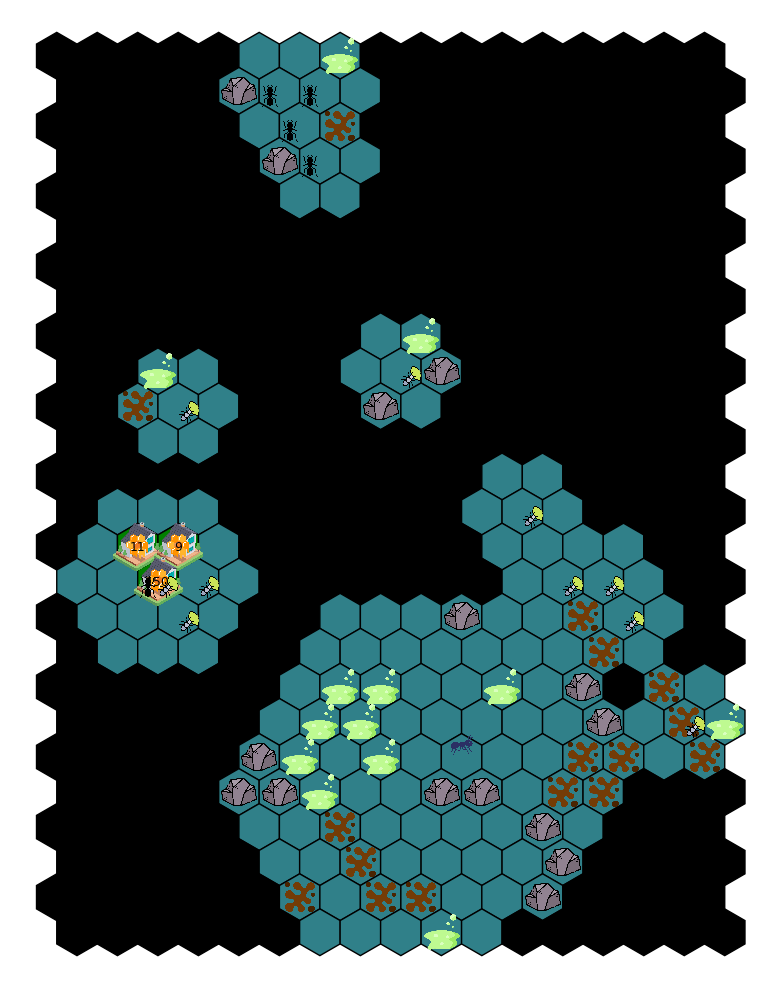

HTTPError: 400 Client Error: Bad Request for url: https://games-test.datsteam.dev/api/move

In [52]:
while True:
    
    data_string = json.dumps(state, ensure_ascii=False, indent=4)
    with open("test2_map.json", "w", encoding="utf-8") as f:
        f.write(data_string)
    
    nodes = [(node["q"], node["r"], node["cost"]) for node in state["map"]]
    graph = create_graph(nodes)
    spot_coords = (state["spot"]["q"], state["spot"]["r"])
    moves = logic(state, graph, spot_coords)
    
    state = api.send_moves(moves)
    
    score = state["score"]
    print("Score: ", score)

    clear_output(wait=True)
    all1(state)

## Tests

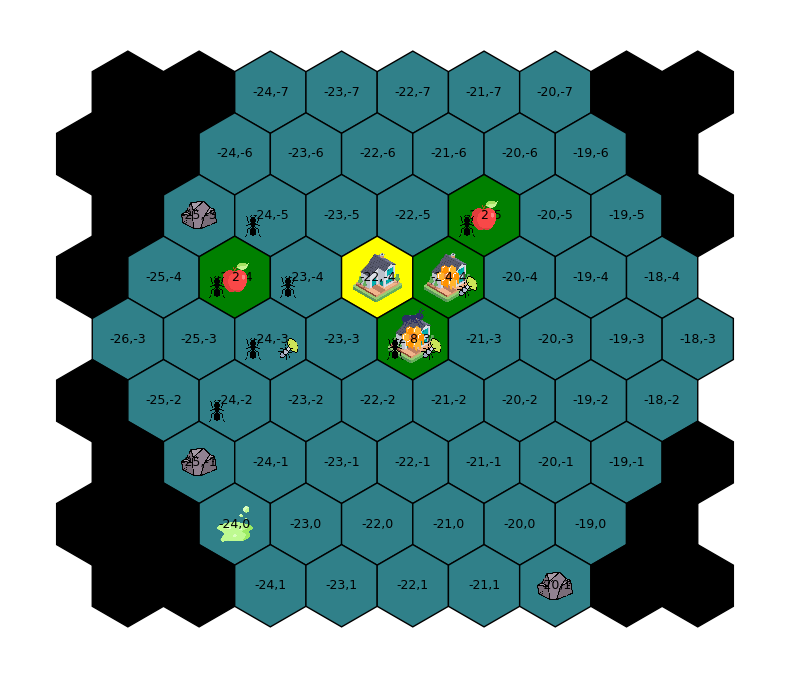

In [33]:
all1(state, paths=None)

In [34]:
ant_workers = []
ant_soldiers = []
ant_finders = []
for ant in state["ants"]:
    if ant["type"] == 0:
        ant_workers.append(ant)
    if ant["type"] == 1:
        ant_soldiers.append(ant)
    if ant["type"] == 2:
        ant_finders.append(ant)

In [40]:
path = go_4_food(ant_workers[2], state["food"], graph, state["ants"])
path

[(-21, -4), (-21, -5)]

In [41]:
ant_workers[2]

{'q': -24,
 'r': -3,
 'type': 0,
 'health': 130,
 'id': '14bda7e2-537b-4815-8b0b-4ffb161728e7',
 'lastMove': [{'q': -24, 'r': -3}],
 'food': {'type': 2, 'amount': 7}}

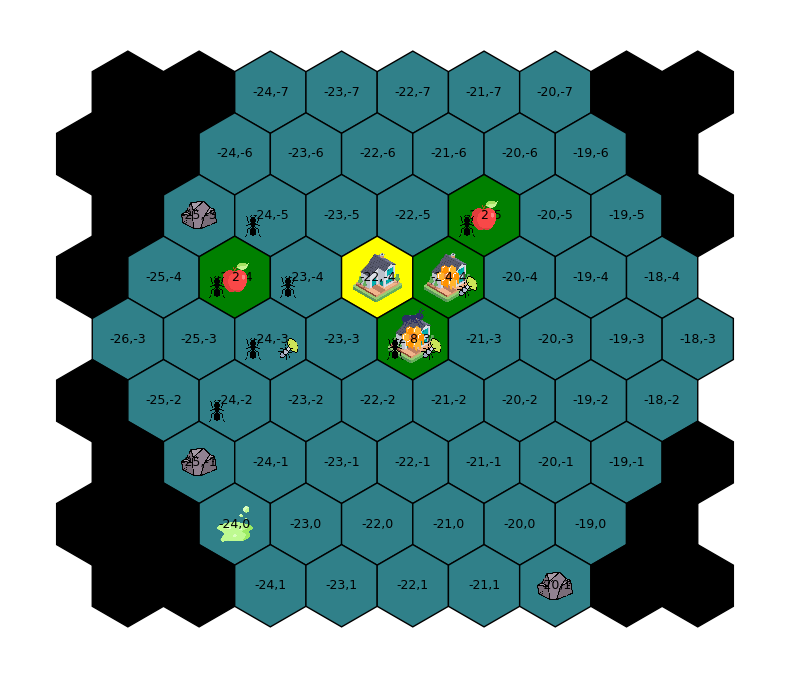

In [38]:
paths = [(path, "#F07272")]
all1(state, paths)

In [54]:
state["score"]

10240